In [5]:
import pandas as pd


def load_raw_dataset(filename='dataset.csv'):
    return pd.read_csv(filename)


raw_dataset = load_raw_dataset()
raw_dataset.head()

,7014440,GB,LONDRES EUSTON,51.527500,-0.132778,7014440.1,GB.1,London Euston,51.314,0.08,1
0,7014440,GB,LONDRES EUSTON,51.527500,-0.132778,8748100,FR,Nantes,47.1301,1.3229,0
1,7014750,GB,LONDRES MARYLEBONE,51.521667,-0.162500,7014750,GB,London Marylebone,51.3123,0.0946,1
2,7014750,GB,LONDRES MARYLEBONE,51.521667,-0.162500,8734218,FR,Maroeuil,50.1920,2.4153,0
3,7029610,GB,MANCHESTER AIRPORT,53.360000,-2.268333,7029610,GB,Manchester Airport,53.2154,2.1620,1
4,7029610,GB,MANCHESTER AIRPORT,53.360000,-2.268333,8728124,FR,Gravelines,50.5843,2.0723,0


In [6]:
def call_counter(func):
    def helper(*args, **kwargs):
        helper.calls += 1
        return func(*args, **kwargs)

    helper.calls = 0
    helper.__name__ = func.__name__
    return helper


def memorize(func):
    mem = {}

    def memoizer(*args, **kwargs):
        key = str(args) + str(kwargs)
        if key not in mem:
            mem[key] = func(*args, **kwargs)
        return mem[key]

    return memoizer


@call_counter
@memorize
def levenshtein(s, t):
    if s == "":
        return len(t)
    if t == "":
        return len(s)
    if s[-1] == t[-1]:
        cost = 0
    else:
        cost = 1

    res = min([levenshtein(s[:-1], t) + 1,
               levenshtein(s, t[:-1]) + 1,
               levenshtein(s[:-1], t[:-1]) + cost])
    return res

In [7]:
from math import sin, cos, sqrt, atan2, radians

class SimilarityVector:
    def __init__(self):
        self.uic = 0
        self.country_similarity = 0
        self.name_distance = 0
        self.geo_distance = 0

    def set_uic(self, uic1, uic2):
        self.uic = levenshtein(uic1, uic2)

    def set_country(self, country1, country2):
        if country1 == country2:
            self.country_similarity = 1
        else:
            self.country_similarity = 0

    def set_name_distance(self, name1, name2):

        self.name_distance = levenshtein(self.__normalize_string(name1),
                                         self.__normalize_string(name2))

    def set_geo_distance(self, lat1, lon1, lat2, lon2):
        radius_earth = 6373.0

        lat1 = radians(lat1)
        lon1 = radians(lon1)
        lat2 = radians(lat2)
        lon2 = radians(lon2)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = radius_earth * c

        self.geo_distance = distance

    def __normalize_string(self, input):

        input = input.lower()
        input = ''.join(c for c in input if c not in ",-' ")

        return input


In [8]:
dataset_x = pd.DataFrame(columns=['uic_similarity','country_similarity','name_distance','geo_distance'])
dataset_y = pd.DataFrame(columns=['match'])
for index, frame in raw_dataset.iterrows():
    
    vector = SimilarityVector()    
    vector.set_uic(frame[0],frame[5])
    vector.set_country(frame[1],frame[6])
    vector.set_name_distance(frame[2],frame[7])
    vector.set_geo_distance(frame[3],frame[4],frame[8],frame[9])
    
    dataset_x = dataset_x.append({
        "uic_similarity": vector.uic,
        "country_similarity": vector.country_similarity,
        "name_distance": vector.name_distance,
        "geo_distance": vector.geo_distance,
          }, ignore_index=True)
    
    dataset_y = dataset_y.append({"match": frame[10],}, ignore_index=True)

In [9]:
dataset_x.head()

,uic_similarity,country_similarity,name_distance,geo_distance
0,6.0,0.0,10.0,500.347283
1,0.0,1.0,3.0,29.332475
2,6.0,0.0,13.0,233.716957
3,0.0,1.0,0.0,294.976788
4,6.0,0.0,15.0,428.552947


In [10]:
dataset_y.shape
dataset_y.head()

,match
0,0
1,1
2,0
3,1
4,0


In [11]:
X_train, X_test, y_train, y_test = dataset_x[:3500], dataset_x[3500:], dataset_y[:3500], dataset_y[3500:]
y_train=y_train.astype('int')

In [12]:
### SGDClassifier and estimation

In [30]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train.values.ravel())

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [31]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train.values.ravel(), cv=3, scoring="accuracy")

array([0.89297945, 0.9897084 , 0.80617496])

In [32]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train.values.ravel(), cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[1749,    1],
       [ 362, 1388]], dtype=int64)

In [33]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_train_pred)

0.9992800575953924

In [34]:
recall_score(y_train, y_train_pred)

0.7931428571428571

In [35]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

0.8843580758203249

In [36]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train.values.ravel(), cv=3,
                             method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

y_scores.shape

(3500,)

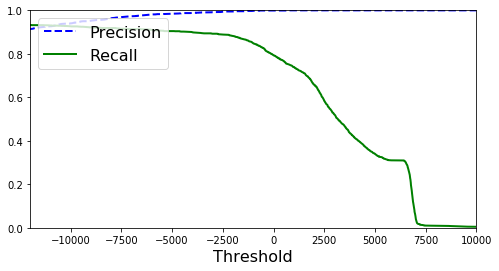

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-12000, 10000])

plt.show()

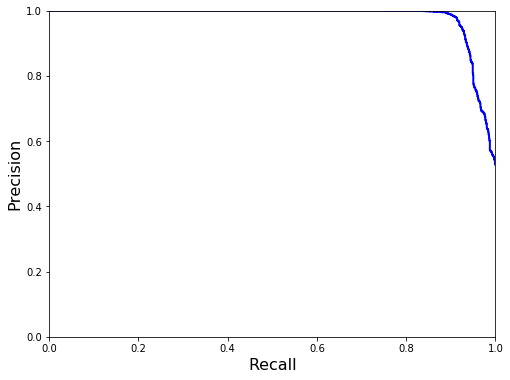

In [38]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

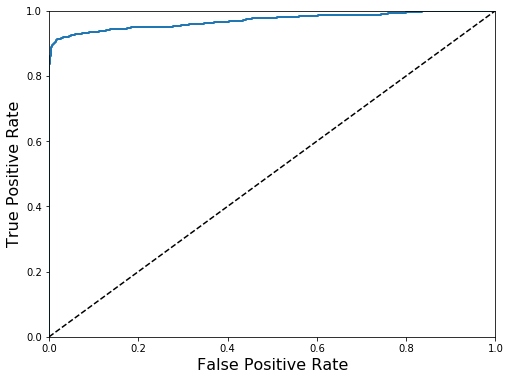

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_scores)

0.9702292244897959

In [41]:
### RandomForestClassifier

In [49]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train.values.ravel(), cv=3,
                                    method="predict_proba")

In [50]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

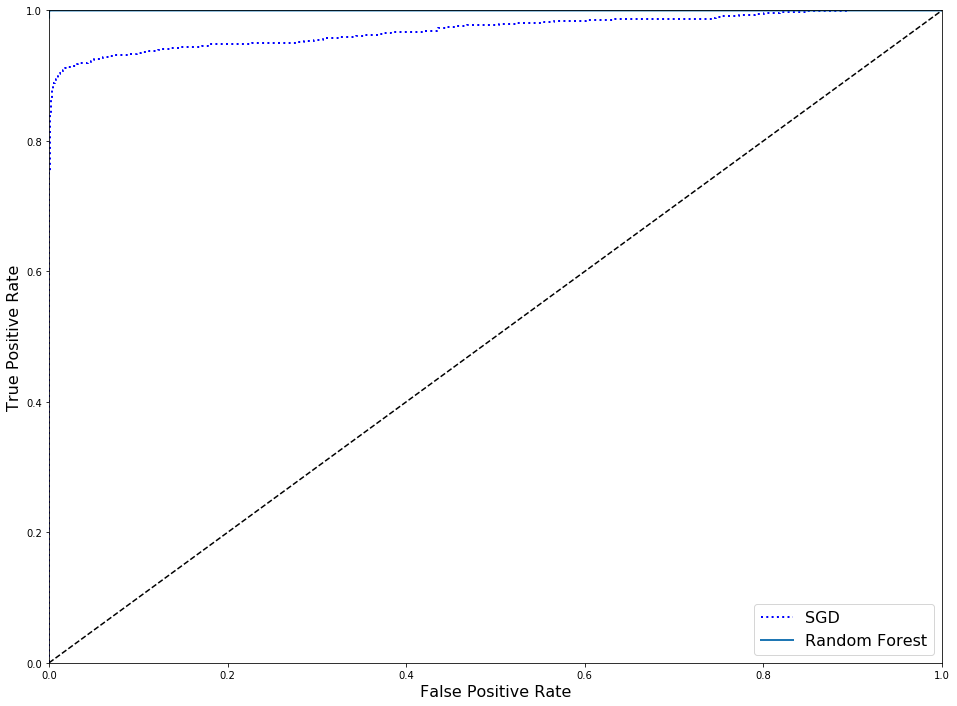

In [51]:
plt.figure(figsize=(16, 12))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)

plt.show()

In [52]:
roc_auc_score(y_train, y_scores_forest)

0.9999993469387755

In [53]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train.values.ravel(), cv=3)
precision_score(y_train, y_train_pred_forest)

1.0

In [54]:
recall_score(y_train, y_train_pred_forest)

0.9994285714285714

In [55]:
### SVM Classifier 

In [56]:
from sklearn.svm import SVC
svm_clf = SVC(kernel="linear", C=100, probability=True)
svm_clf.fit(X_train, y_train.values.ravel())

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [57]:
y_probas_svm = cross_val_predict(svm_clf, X_train, y_train.values.ravel(), cv=3,
                                    method="predict_proba")

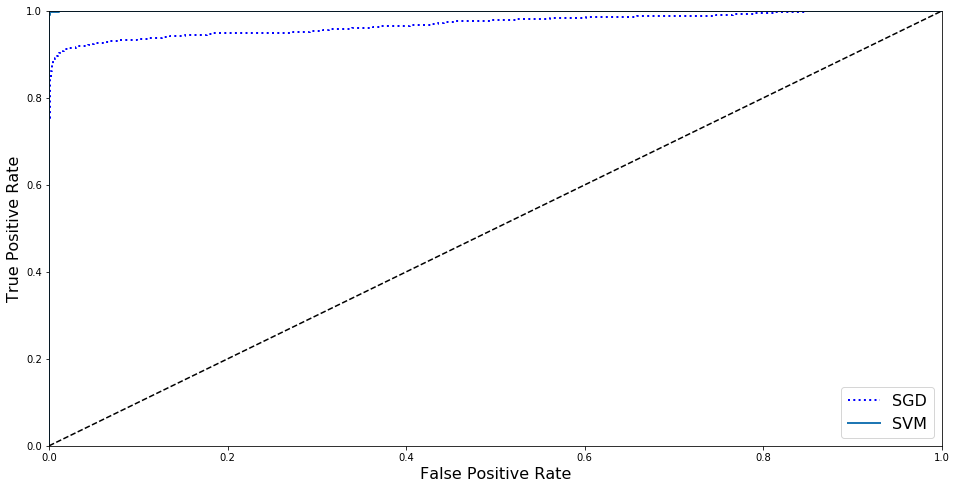

In [58]:
y_scores_svm = y_probas_svm[:, 1] # score = proba of positive class
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, y_scores_svm)

plt.figure(figsize=(16, 8))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_svm, tpr_svm, "SVM")
plt.legend(loc="lower right", fontsize=16)

plt.show()